In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
dataset_path = Path("../Datasets")
image_size = (160, 160)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_indices = train_generator.class_indices
index_to_user = {v: k for k, v in class_indices.items()}
print("Label Index Mapping:", index_to_user)


Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Label Index Mapping: {0: 'rathin_861884c7-4ea4-4d7d-8878-2a9cf5b524f8', 1: 'shrayanmandal_0067062c-4036-475a-9432-2bdb590b2d62'}


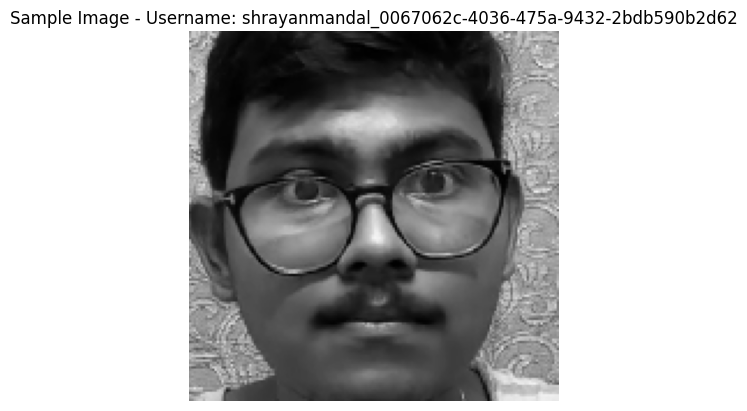

In [14]:
# Grab a batch of images and labels
images, labels = next(train_generator)

# Show the first image and its label
plt.imshow(images[0])
plt.axis("off")

# Convert one-hot to label index
label_index = np.argmax(labels[0])
label_name = index_to_user[label_index]
plt.title(f"Sample Image - Username: {label_name}")
plt.show()


In [15]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.8377 - loss: 0.4472 - val_accuracy: 1.0000 - val_loss: 1.8586e-04
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 1.0000 - loss: 3.1339e-04 - val_accuracy: 1.0000 - val_loss: 2.3021e-05
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 3.2253e-04 - val_accuracy: 1.0000 - val_loss: 8.2709e-06
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 5.9745e-05 - val_accuracy: 1.0000 - val_loss: 5.2769e-06
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 1.9650e-05 - val_accuracy: 1.0000 - val_loss: 4.0292e-06
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 5.2906e-05 - val_accuracy: 1.0000 - val_loss: 3.6080e-06
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 1.7039e-05 - val_accuracy: 1.0000 - val_loss: 3.4451e-06
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accura

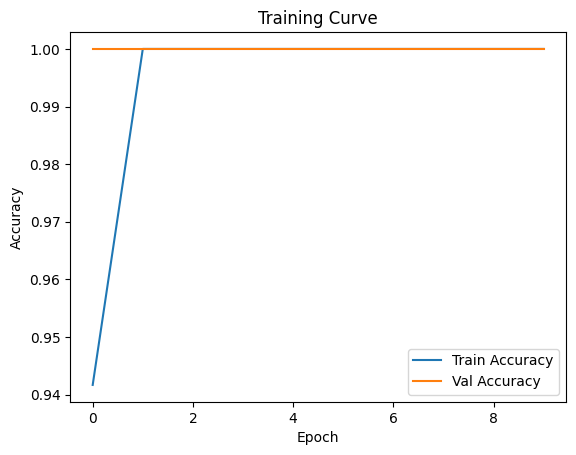

In [17]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [18]:
model.save("face_id_model.h5")

import json
with open("username_map.json", "w") as f:
    json.dump(index_to_user, f)

In [22]:
from tensorflow.keras.preprocessing import image
import json

# Load model and mapping
model = tf.keras.models.load_model("face_id_model.h5")
with open("username_map.json") as f:
    index_to_user = json.load(f)

def predict_username(img_path):
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]
    predicted_index = np.argmax(preds)
    confidence = preds[predicted_index]
    predicted_user = index_to_user[str(predicted_index)]
    return predicted_user, float(confidence)

# Example
predict_username("cache/rathin.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


('rathin_861884c7-4ea4-4d7d-8878-2a9cf5b524f8', 0.75248122215271)